In [1]:
from functions import *

In [2]:
if os.path.isfile('config.yml'):
    config_path = 'config.yml'

else:
    config_path = 'sample_config.yml'

config = parse_yml(config_path)

datelist_red = ['20081212']

spacecraft = ['A']

ins_list = ['hi_1']

data_type = ['science']

num = 0

if data_type[num] == 'science':
    path_flg = 'L0'

if data_type[num] == 'beacon':
    path_flg = 'beacon'

bg_dur = 1

In [1]:
def data_reduction(start, path, datpath, ftpsc, instrument, bflag, silent, save_path, path_flg):
    """
    Data reduciton routine calling upon various functions converted from IDL. The default correction procedure involves;
    correcting for shutterless exposure, multiplying by the flatfield, subtracting the bias,
    accounting for seb-ip binning, and desaturating the data. This process implicity performs conversion to DN/s.
    Procedure also adds best calibrated pointing into HI header.

    @param start: Start date of Jplot
    @param path: The path where all reduced images, running difference images and J-Maps are saved
    @param datpath: Path to STEREO-HI calibration files
    @param ftpsc: Spacecraft (A/B)
    @param instrument: STEREO-HI instrument (HI-1/HI-2)
    @param bflag: Science or beacon data
    @param silent: Run in silent mode
    @param save_path: Path pointing towards downloaded STEREO .fits files
    @param path_flg: Specifies path for downloaded files, depending on wether science or beacon data is used
    """
    if not silent:
        print('----------------')
        print('DATA REDUCTION')
        print('----------------')

    if ftpsc == 'A':
        sc = 'ahead'

    if ftpsc == 'B':
        sc = 'behind'

    savepath = path + 'reduced/data/' + ftpsc + '/' + start + '/' + bflag + '/'
    calpath = datpath + 'calibration/'
    pointpath = datpath + 'data' + '/' + 'hi/'
            
    for ins in instrument:
        fitsfiles = []

        if bflag == 'science':
            for file in sorted(glob.glob(save_path + 'stereo' + sc[0] + '/secchi/' + path_flg + '/img/'+ins+'/' + str(start) + '/*s4*.fts')):
                fitsfiles.append(file)
    
        if bflag == 'beacon':
            for file in sorted(glob.glob(save_path + 'stereo' + sc[0] + '/' + path_flg + '/secchi/img/'+ins+'/' + str(start) + '/*s7*.fts')):
                fitsfiles.append(file)
        
        if len(fitsfiles) == 0:
            print('No files found for ', ins, ' on ', start)
            continue

        if not silent:
            print('----------------------------------------')
            print('Starting data reduction for', ins, '...')
            print('----------------------------------------')

        # correct for on-board sebip modifications to image (division by 2, 4, 16 etc.)
        # calls function scc_sebip

        hdul = [fits.open(fitsfiles[i]) for i in range(len(fitsfiles))]

        hdul_data = np.array([hdul[i][0].data for i in range(len(hdul))])
        hdul_header = [hdul[i][0].header for i in range(len(hdul))]

        rectify = [hdul_header[i]['rectify'] for i in range(len(hdul))]

        ## CHANGE rectify inserted here
        for i in range(len(hdul)):
            if rectify[i] != True:
                hdul_header[i]['r1col'] = hdul_header[i]['p1col']
                hdul_header[i]['r2col'] = hdul_header[i]['p2col']
                hdul_header[i]['r1row'] = hdul_header[i]['p1row']
                hdul_header[i]['r2row'] = hdul_header[i]['p2row']

        rectify_on =  True

        if rectify_on == True:                    
            for i in range(len(hdul)):
                if rectify[i] != True:
                    hdul_data[i], hdul_header[i] = secchi_rectify(hdul_data[i], hdul_header[i])

        ## CHANGE implemented precommcorrect here, is necessary for COR1, optional for HI

        precomcorrect_on = False

        if precomcorrect_on == False:

            if ftpsc == 'A':
                date_cutoff = datetime.datetime.strptime('2007-02-03T13:15', '%Y-%m-%dT%H:%M')
            else:
                date_cutoff = datetime.datetime.strptime('2007-02-21T21:00', '%Y-%m-%dT%H:%M')

            precomcorrect_on = (ins == 'cor1') and (hdul_header[0]['date_obs'] < date_cutoff) and (hdul_header[0]['date'] < datetime.datetime.strptime('2008-01-17', '%Y-%m-%d'))

        if precomcorrect_on == True:

            for i in range(len(hdul)):
                xh = hdul[i][1].header
                cnt_exp = np.where(xh['EXPTIME'] == 0)[0]

                if len(cnt_exp) <= 0:
                    hdul_header[i]['EXPTIME'] = np.sum(xh['EXPTIME'])

                hdul_data[i], hdul_header[i] = precommcorrect(hdul_data[i], hdul_header[i], silent=silent)
        
        if bflag == 'science':
            if ins == 'hi_1':
                norm_img = 30
                acc_img = 15

            else:
                norm_img = 99
                acc_img = 99

        if bflag == 'beacon':
            norm_img = 1
            acc_img = 1
            
        indices = []
        bad_img = []
    
        n_images = [hdul_header[i]['n_images'] for i in range(len(hdul_header))]

        if not all(val == norm_img for val in n_images):

            bad_ind = [i for i in range(len(n_images)) if (n_images[i] != norm_img) and (n_images[i] != acc_img)]
            good_ind = [i for i in range(len(n_images)) if (n_images[i] == norm_img) or (n_images[i] == acc_img)]
            bad_img.extend(bad_ind)
            indices.extend(good_ind)

        else:
            indices = [i for i in range(len(fitsfiles))]

        crval1_test = [int(np.sign(hdul_header[i]['crval1'])) for i in indices]
        
        if len(set(crval1_test)) > 1:

            common_crval = Counter(crval1_test)
            com_val, count = common_crval.most_common()[0]
            
            bad_ind = [i for i in range(len(crval1_test)) if crval1_test[i] != com_val]
            
            for i in sorted(bad_ind, reverse=True):
                bad_img.extend([indices[i]])
                del indices[i]   
                
            if len(bad_ind) >= len(indices):
                print('Too many corrupted images - can\'t determine correct CRVAL1. Exiting...')
                sys.exit()


        if bflag == 'science':
            #Must find way to do this for beacon also
            datamin_test = [hdul_header[i]['DATAMIN'] for i in indices]
            
            if not all(val == norm_img for val in datamin_test):
                
                bad_ind = [i for i in range(len(datamin_test)) if datamin_test[i] != norm_img]

                for i in sorted(bad_ind, reverse=True):
                    bad_img.extend([indices[i]])
                    del indices[i]

        if bflag == 'beacon':
            test_data = np.array([hdul_data[i] for i in indices])
            test_data = np.where(test_data == 0, np.nan, test_data)
            
            bad_ind = [i for i in range(len(test_data)) if np.isnan(test_data[i]).all() == True]
            
            for i in sorted(bad_ind, reverse=True):
                bad_img.extend([indices[i]])
                del indices[i]
                    
        missing_ind = np.array([hdul_header[i]['NMISSING'] for i in indices])

        bad_ind = [i for i in range(len(missing_ind)) if missing_ind[i] > 0]
        for i in sorted(bad_ind, reverse=True):
            bad_img.extend([indices[i]])
            del indices[i]     
        
        clean_data = []
        clean_header = []
        
        for i in range(len(fitsfiles)):
            if i in indices:
                clean_data.append(hdul_data[i])
                clean_header.append(hdul_header[i])
                hdul[i].close()
            else:
                hdul[i].close()
        
        clean_data = np.array(clean_data)

        if bflag == 'beacon':
            for i in range(len(clean_header)):
                hi_fix_beacon_date(clean_header[i])

        crval1 = [clean_header[i]['crval1'] for i in range(len(clean_header))]

        if ftpsc == 'A':    
            post_conj = [int(np.sign(crval1[i])) for i in range(len(crval1))]
    
        if ftpsc == 'B':    
            post_conj = [int(-1*np.sign(crval1[i])) for i in range(len(crval1))]
        
        if len(clean_header) == 0:
            print('No clean files found for ', ins, ' on ', start)
            return

        if len(set(post_conj)) == 1:

            post_conj = post_conj[0]
    
            if post_conj == -1:
                post_conj = False
            if post_conj == 1:
                post_conj = True

        else:
            print('Corrupted CRVAL1 in header. Exiting...')
            sys.exit()
        
        trim_off = False
        
        if trim_off == False:
            for i in range(len(clean_data)):
                clean_data[i], clean_header[i] = scc_img_trim(clean_data[i], clean_header[i], silent=silent)
        
        # for i in range(len(clean_data)):
        #     clean_data[i], clean_header[i] = scc_putin_array(clean_data[i], clean_header[i], trim_off=trim_off, silent=silent)

        ## TODO: Implement discri_pobj.pro

        ## TODO: Implement COR_PREP.pro

        ## TODO: Implement COR_POLARIZ.pro

        ## TODO: Implement EUVI_PREP.pro

        if ins == 'hi_1':
            
            nocalfac_butcorrforipsum = True

            kw_args = {
                'rectify_on' : rectify_on,
                'precomcorrect_on' : precomcorrect_on,
                'trim_off' : trim_off,
                'nocalfac_butcorrforipsum': True,
                'calibrate_on': True,
                'smask_on': False,
                'fill_mean': True,
                'fill_value': None,
                'update_hdr_on': True,
                'sebip_off': False,
                'calimg_off': False,
                'desmear_off': False,
                'calfac_off': nocalfac_butcorrforipsum,
                'exptime_off': False,
                'bias_off': False,
                'silent': silent,
            }

            for i in range(len(clean_data)):
                clean_data[i], clean_header[i] = hi_prep(clean_data[i], clean_header[i], post_conj, calpath, pointpath, **kw_args)


        elif ins == 'hi_2':

            nocalfac_butcorrforipsum = True

            kw_args = {
                'rectify_on' : rectify_on,
                'precomcorrect_on' : precomcorrect_on,
                'trim_off' : trim_off,
                'nocalfac_butcorrforipsum': True,
                'calibrate_on': True,
                'smask_on': True,
                'fill_mean': True,
                'fill_value': None,
                'update_hdr_on': True,
                'sebip_off': False,
                'calimg_off': False,
                'desmear_off': False,
                'calfac_off': nocalfac_butcorrforipsum,
                'exptime_off': False,
                'bias_off': False,
                'silent': silent,
            }

            for i in range(len(clean_data)):
                clean_data[i], clean_header[i] = hi_prep(clean_data[i], clean_header[i], post_conj, calpath, pointpath, **kw_args)
            
        
        return clean_data, clean_header

In [4]:
clean_data, clean_header = data_reduction(datelist_red[num], config['output_directory'], config['solarsoft_directory'], spacecraft[num], ins_list, config['data_type'][num], config['silent_mode'], config['data_directory'], path_flg)

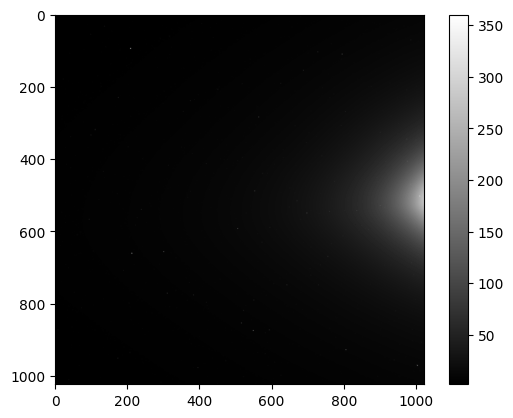

In [10]:
from astropy.io import fits

# Specify the path to the FITS file
fits_file = '/home/mbauer/Data/stereo_processed/reduced/data/A/20081212/science/hi_1/20081212_235840_1bh1A.fts'

# Read the FITS file
hdul = fits.open(fits_file)
data = hdul[0].data

# Create a new figure
fig = plt.figure()

# Display the data
plt.imshow(np.flipud(data), cmap='gray')

# Add a colorbar
plt.colorbar()

# Show the figure
plt.show()

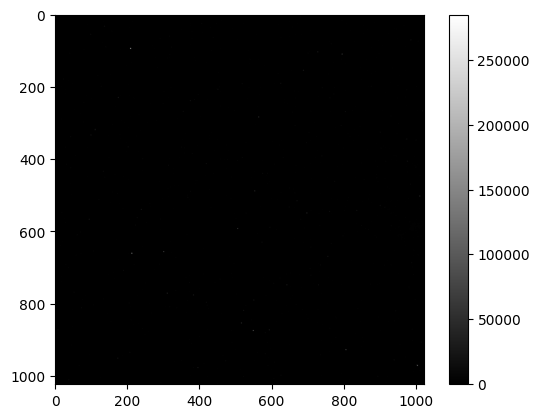

In [6]:

# Specify the path to the FITS file
fits_file_david = '/home/mbauer/Data/20081212_232901_2th1A_br01.fts'

# Read the FITS file
hdul_david = fits.open(fits_file_david)
data_david = hdul_david[0].data

# Create a new figure
fig = plt.figure()

# Display the data
plt.imshow(np.flipud(data_david), cmap='gray')

# Add a colorbar
plt.colorbar()

# Show the figure
plt.show()

In [8]:
hdul_david[0].header['History']

Id: make_scc_hdr.pro,v 1.153 2008/10/07 16:54:49 nathan Exp
Id: getsccsecpix.pro,v 1.15 2008/05/02 17:09:59 nathan Exp
Id: getscccrpix.pro,v 1.8 2007/03/30 19:31:59 nathan Exp
Id: getsccpointing.pro,v 1.9 2008/04/17 15:14:01 nathan Exp
Id: secchi_reduce.pro,v 1.291 2008/12/11 19:27:55 mcnutt Exp
Processed on mimas: sparc Solaris IDL6.2
Id: secchi_rectify.pro,v 1.21 2008/07/14 18:34:16 nathan Exp
Id: hi_point_v2.pro,v 1.13 2008/03/12 21:07:54 nathan Exp
Applied hi_correction.pro,v 1.15 2009/06/08 11:03:37 crothers
Applied hi_desmear.pro,v 1.8 2007/09/04 17:01:21 crothers
get_calfac Divided calfac by 4 to account for IPSUM
Applied calibration factor 0.250000
Applied Flat Field 20100421_flatfld_sum_h1a.fts
1 day running background, average of smallest 25%
Applied diffuse source correction

In [11]:
hdul[0].header['History']

Id: make_scc_hdr.pro,v 1.153 2008/10/07 16:54:49 nathan Exp
Id: getsccsecpix.pro,v 1.15 2008/05/02 17:09:59 nathan Exp
Id: getscccrpix.pro,v 1.8 2007/03/30 19:31:59 nathan Exp
Id: getsccpointing.pro,v 1.9 2008/04/17 15:14:01 nathan Exp
Id: secchi_reduce.pro,v 1.291 2008/12/11 19:27:55 mcnutt Exp
Processed on mimas: sparc Solaris IDL6.2
Id: secchi_rectify.pro,v 1.21 2008/07/14 18:34:16 nathan Exp
Id: hi_point_v2.pro,v 1.13 2008/03/12 21:07:54 nathan Exp
Applied hi_correction.pro,v 1.20 2015/02/09 14:43:14 crothers
Applied hi_desmear.pro,v 1.11 2023/08/15 16:22:32
Applied Flat Field 20100421_flatfld_sum_h1a.fts
image Divided by 4.0 to account for IPSUM

In [21]:
from scipy.ndimage import generic_filter

In [16]:
i = 0
bkgd_data = get_bkgd(config['output_directory'], config['spacecraft'][num], datelist_red[i], config['data_type'][num], ins_list[num], bg_dur)

bkgd_data = np.nan_to_num(bkgd_data, np.nanmedian(bkgd_data))
# bkgd = np.nanmedian(bkgd_data, axis=0)

thresh = np.nanpercentile(bkgd_data, 25, axis=0)

data_comp = np.zeros(bkgd_data.shape)

for i, dat in enumerate(bkgd_data):
    data_comp[i] = np.where(dat <= thresh, dat, np.nan)

# bkgd_mean = np.nanmean(data_comp, axis=0)

data_nobg = data - bkgd_data

# data_nobg_mean = data - bkgd_mean

In [17]:
def robust_mean_arr(arr):
    median = np.median(arr)
    med_std = np.median(np.abs(arr - median))

    temp_arr = arr.copy()
    temp_arr[np.abs(temp_arr) > np.abs(median)+2*med_std] = 2147483647

    return temp_arr[temp_arr != 2147483647].mean()

In [18]:
def tresh_arr(arr):
    median = np.median(arr)
    med_std = np.median(np.abs(arr - median))

    return np.abs(median)+2*med_std

In [22]:
data_nobg_scaled = np.zeros(data_nobg.shape)


for i in range(data_nobg.shape[0]):
    p2, p98 = np.percentile(data_nobg[i], (1, 99))
    data_nobg_scaled[i] = exposure.rescale_intensity(data_nobg[i], in_range=(p2, p98))
    #data_nobg_mean_scaled[i] = minmax_scaler(data_nobg_mean[i].copy(), vmin=0, vmax=1)
    data_nobg_scaled[i] = exposure.adjust_log(minmax_scaler(data_nobg_scaled[i],vmin=0,vmax=1), 1)

In [23]:
img = data_nobg_scaled.copy()
img = np.where(np.isnan(img), np.nanmedian(img), img)

rob_mean_arr = generic_filter(img, robust_mean_arr, size=21)
thresh_arr = generic_filter(img, tresh_arr, size=21)

In [24]:
fin_img = np.where(np.abs(img) > thresh_arr, rob_mean_arr, img)

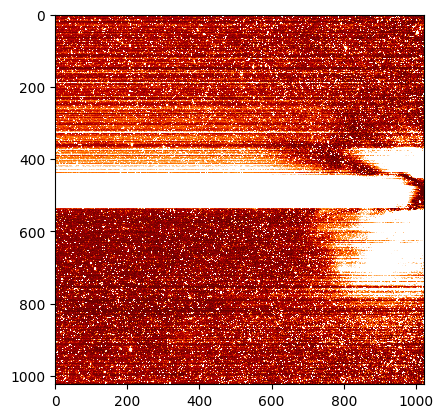

In [25]:
from matplotlib.colors import LogNorm
vmin = np.median(data_nobg_scaled) - np.std(data_nobg_scaled)
vmax = np.median(data_nobg_scaled) + np.std(data_nobg_scaled)
plt.imshow(data_nobg_scaled, cmap='gist_heat', interpolation='none', vmin=vmin, vmax=vmax)

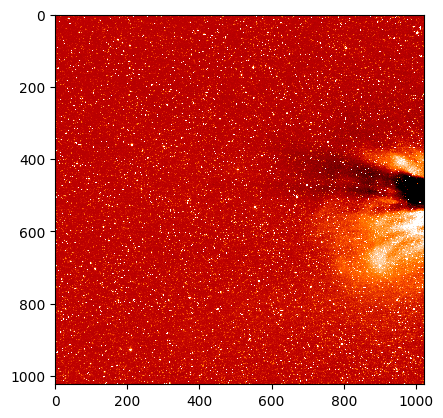

In [30]:
f = 0.5
vmin = np.median(data_nobg) - f*np.std(data_nobg)
vmax = np.median(data_nobg) + f*np.std(data_nobg)
plt.imshow(data_nobg, cmap='gist_heat', interpolation='none', vmin=vmin, vmax=vmax)

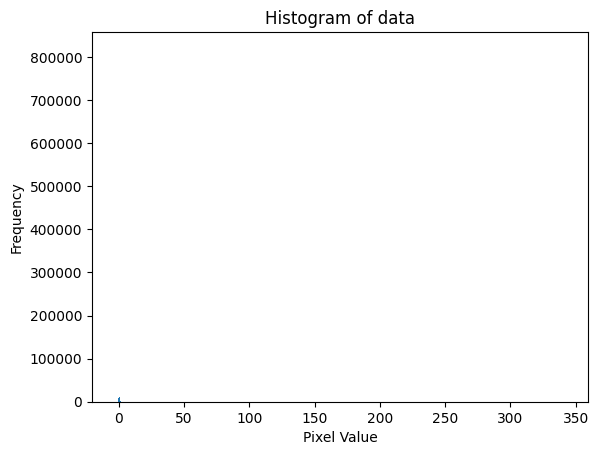

In [36]:
fig_hist = plt.figure()
plt.hist(data_nobg.flatten(), bins=2500)
# plt.ylim(0, 50000)
#
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of data')
plt.show()

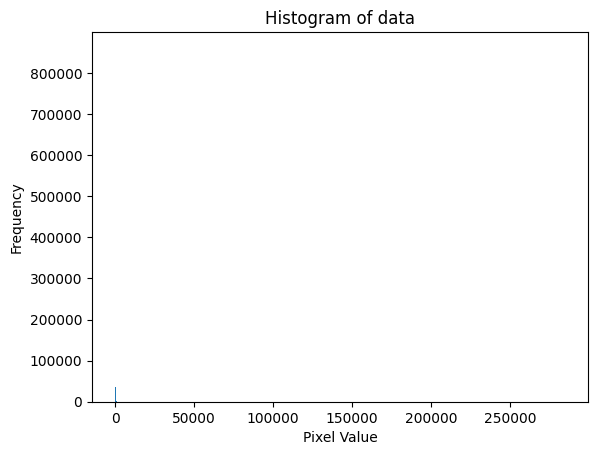

In [35]:
fig_hist = plt.figure()
plt.hist(data_david.flatten(), bins=2500)
# plt.ylim(0, 50000)
#
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of data')
plt.show()